# Unsupervised Anomaly Detection in Cloud Network Traffic

In [1]:
import pandas as pd

# Specify the folder containing Parquet files
folder_path = 'raw_data'

# Read all Parquet files in the folder into a single DataFrame
df = pd.read_parquet(folder_path)

# Verify the data
print(df.shape)
print(df.head())

C:\Users\Arpita\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Arpita\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(170665, 22)
    timestamp                                              event session_id  \
0  1593481283  {"data":"","encrypted":false,"key":"","lsh":"0...   6CzwqYpV   
1  1593481284  {"data":"SFRUUC8xLjEgNDAwIEJhZCBSZXF1ZXN0DQpEY...   ydwTG1Wp   
2  1593481284  {"data":"I1NUCg==","encrypted":false,"key":"",...   HkYZE1kJ   
3  1593481285  {"data":"AAtuAAAAAAEEYmVpbw==","encrypted":fal...   wHr1ZYOg   
4  1593481282  {"data":"","encrypted":false,"key":"","lsh":"0...   XoPUTpQH   

   source_port  destination_port        source_ip        sensor_ip  \
0        55662              2082  172.104.144.250  157.245.219.132   
1        38746              8443   222.186.19.210  206.189.232.253   
2        56562              2082  172.104.144.250  157.245.219.132   
3        57408              2082  172.104.144.250  157.245.219.132   
4        64839              5900     193.27.228.9    34.105.14.146   

    destination_ip meta_type                            event_uuid  ...  \
0  157.245.219.1

# Preprocessing

checking for missing values

In [2]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

timestamp           0.0
event               0.0
session_id          0.0
source_port         0.0
destination_port    0.0
source_ip           0.0
sensor_ip           0.0
destination_ip      0.0
meta_type           0.0
event_uuid          0.0
sensor_uuid         0.0
hostname            0.0
project             0.0
provider            0.0
region              0.0
protocol            0.0
app_protocol        0.0
3wh                 0.0
ip_version          0.0
metadata            0.0
vpn                 0.0
vpn_service         0.0
dtype: float64


In [3]:
df.dtypes

timestamp            int32
event               object
session_id          object
source_port          int64
destination_port     int32
source_ip           object
sensor_ip           object
destination_ip      object
meta_type           object
event_uuid          object
sensor_uuid         object
hostname            object
project             object
provider            object
region              object
protocol            object
app_protocol        object
3wh                   bool
ip_version           int32
metadata            object
vpn                   bool
vpn_service         object
dtype: object

In [4]:
df.rename(columns={'region':'org_region'},inplace=True)

In [5]:
df.columns

Index(['timestamp', 'event', 'session_id', 'source_port', 'destination_port',
       'source_ip', 'sensor_ip', 'destination_ip', 'meta_type', 'event_uuid',
       'sensor_uuid', 'hostname', 'project', 'provider', 'org_region',
       'protocol', 'app_protocol', '3wh', 'ip_version', 'metadata', 'vpn',
       'vpn_service'],
      dtype='object')

In [6]:
df['metadata'].head()

0    {'category': 'hosting', 'city': 'Frankfurt am ...
1    {'category': 'hosting', 'city': 'Shanghai', 'd...
2    {'category': 'hosting', 'city': 'Frankfurt am ...
3    {'category': 'hosting', 'city': 'Frankfurt am ...
4    {'category': 'hosting', 'city': 'Saint Petersb...
Name: metadata, dtype: object

# Handling Metadata Column(Contains Python Dictionary)

In [7]:
# Expand the 'metadata' column into separate columns
df_metadata = df['metadata'].apply(pd.Series)
df_metadata.head()


,category,city,domain,mobile,country,region,long,tor,rdns_validated,country_code,lat,org,postal,type,asn,datacenter,rdns_parent,rdns,url,phone
0,hosting,Frankfurt am Main,linode.com,False,Germany,Hesse,8.6842,False,False,DE,50.1155,"Linode, LLC",60311.0,hosting,AS63949,None,binaryedge.ninja,172.104.144.250.li.binaryedge.ninja,None,None
1,hosting,Shanghai,cn.net,False,China,Shanghai,121.4581,False,False,CN,31.2222,AS Number for CHINANET jiangsu province backbone,NaN,hosting,AS23650,None,None,None,None,None
2,hosting,Frankfurt am Main,linode.com,False,Germany,Hesse,8.6842,False,False,DE,50.1155,"Linode, LLC",60311.0,hosting,AS63949,None,binaryedge.ninja,172.104.144.250.li.binaryedge.ninja,None,None
3,hosting,Frankfurt am Main,linode.com,False,Germany,Hesse,8.6842,False,False,DE,50.1155,"Linode, LLC",60311.0,hosting,AS63949,None,binaryedge.ninja,172.104.144.250.li.binaryedge.ninja,None,None
4,hosting,Saint Petersburg,hostway.ru,False,Russia,St.-Petersburg,30.3141,False,False,RU,59.9386,OOO Network of data-centers Selectel,190000.0,hosting,AS49505,None,None,None,None,None


In [8]:
# Concatenate with the original DataFrame
df = pd.concat([df.drop(columns='metadata'), df_metadata], axis=1)

df.head()

,timestamp,event,session_id,source_port,destination_port,source_ip,sensor_ip,destination_ip,meta_type,event_uuid,...,lat,org,postal,type,asn,datacenter,rdns_parent,rdns,url,phone
0,1593481283,"{""data"":"""",""encrypted"":false,""key"":"""",""lsh"":""0...",6CzwqYpV,55662,2082,172.104.144.250,157.245.219.132,157.245.219.132,response,b293c2bd-a9d8-4288-8932-58ef845e3b18,...,50.1155,"Linode, LLC",60311.0,hosting,AS63949,None,binaryedge.ninja,172.104.144.250.li.binaryedge.ninja,None,None
1,1593481284,"{""data"":""SFRUUC8xLjEgNDAwIEJhZCBSZXF1ZXN0DQpEY...",ydwTG1Wp,38746,8443,222.186.19.210,206.189.232.253,206.189.232.253,persona,a22ad20e-cc63-4c2f-95d5-e62ebf76e883,...,31.2222,AS Number for CHINANET jiangsu province backbone,NaN,hosting,AS23650,None,None,None,None,None
2,1593481284,"{""data"":""I1NUCg=="",""encrypted"":false,""key"":"""",...",HkYZE1kJ,56562,2082,172.104.144.250,157.245.219.132,157.245.219.132,response,a412acd4-3b4a-4a5e-ba05-35cc9fbe6d0d,...,50.1155,"Linode, LLC",60311.0,hosting,AS63949,None,binaryedge.ninja,172.104.144.250.li.binaryedge.ninja,None,None
3,1593481285,"{""data"":""AAtuAAAAAAEEYmVpbw=="",""encrypted"":fal...",wHr1ZYOg,57408,2082,172.104.144.250,157.245.219.132,157.245.219.132,response,16972fd5-452a-4792-addb-ba2111d14de1,...,50.1155,"Linode, LLC",60311.0,hosting,AS63949,None,binaryedge.ninja,172.104.144.250.li.binaryedge.ninja,None,None
4,1593481282,"{""data"":"""",""encrypted"":false,""key"":"""",""lsh"":""0...",XoPUTpQH,64839,5900,193.27.228.9,34.105.14.146,10.138.0.62,response,b8ddd71b-b756-4005-8d9c-606fdf87dd17,...,59.9386,OOO Network of data-centers Selectel,190000.0,hosting,AS49505,None,None,None,None,None


In [9]:
df.shape

(170665, 41)

# Handling Event Column(Contains JSON Dictionary)

In [10]:
# Convert JSON strings to dictionaries
import json
df['event'] = df['event'].apply(json.loads)

# Normalize the 'event' column
event_df = pd.json_normalize(df['event'])
event_df.head()


,data,encrypted,key,lsh,rtt,size,timeout,xxh
0,,False,,07d0000000000000c00000300000000000000000000000...,0,0,False,ef46db3751d8e999
1,SFRUUC8xLjEgNDAwIEJhZCBSZXF1ZXN0DQpEYXRlOiBNb2...,False,,48f0e1fb92833199852306a01ec1fed6337006e5f65a85...,0,95,False,283f8d85935ef0b2
2,I1NUCg==,False,,35d0000000000000ccc300300f000000c00000003c0c00...,0,4,False,899236b5999a8085
3,AAtuAAAAAAEEYmVpbw==,False,,20d000c80208a000c20802b380000000a080888000a000...,0,13,False,40fb20adfc73e903
4,,False,,07d0000000000000c00000300000000000000000000000...,0,0,False,ef46db3751d8e999


In [11]:
# Concatenate with the original DataFrame
df1 = pd.concat([df.drop(columns='event'), event_df], axis=1)
df1.head()

# remove this columns --> data,url,phone,key,lsh,rtt,xxh,postal,org,lat,rdns validated,long,country_code,mobile
# domain,city,ip_version,project,evevt_uuid,source_port,destination_port,session_id,timestamp

,timestamp,session_id,source_port,destination_port,source_ip,sensor_ip,destination_ip,meta_type,event_uuid,sensor_uuid,...,url,phone,data,encrypted,key,lsh,rtt,size,timeout,xxh
0,1593481283,6CzwqYpV,55662,2082,172.104.144.250,157.245.219.132,157.245.219.132,response,b293c2bd-a9d8-4288-8932-58ef845e3b18,12368c8a-ba55-744d-3edf-0b8826aaa4e0,...,None,None,,False,,07d0000000000000c00000300000000000000000000000...,0,0,False,ef46db3751d8e999
1,1593481284,ydwTG1Wp,38746,8443,222.186.19.210,206.189.232.253,206.189.232.253,persona,a22ad20e-cc63-4c2f-95d5-e62ebf76e883,2353e17b-fde5-aa6e-e945-90558a5c741e,...,None,None,SFRUUC8xLjEgNDAwIEJhZCBSZXF1ZXN0DQpEYXRlOiBNb2...,False,,48f0e1fb92833199852306a01ec1fed6337006e5f65a85...,0,95,False,283f8d85935ef0b2
2,1593481284,HkYZE1kJ,56562,2082,172.104.144.250,157.245.219.132,157.245.219.132,response,a412acd4-3b4a-4a5e-ba05-35cc9fbe6d0d,12368c8a-ba55-744d-3edf-0b8826aaa4e0,...,None,None,I1NUCg==,False,,35d0000000000000ccc300300f000000c00000003c0c00...,0,4,False,899236b5999a8085
3,1593481285,wHr1ZYOg,57408,2082,172.104.144.250,157.245.219.132,157.245.219.132,response,16972fd5-452a-4792-addb-ba2111d14de1,12368c8a-ba55-744d-3edf-0b8826aaa4e0,...,None,None,AAtuAAAAAAEEYmVpbw==,False,,20d000c80208a000c20802b380000000a080888000a000...,0,13,False,40fb20adfc73e903
4,1593481282,XoPUTpQH,64839,5900,193.27.228.9,34.105.14.146,10.138.0.62,response,b8ddd71b-b756-4005-8d9c-606fdf87dd17,a61b594b-e136-8c80-01a7-b2fda36d03e0,...,None,None,,False,,07d0000000000000c00000300000000000000000000000...,0,0,False,ef46db3751d8e999


In [12]:
df1.columns

Index(['timestamp', 'session_id', 'source_port', 'destination_port',
       'source_ip', 'sensor_ip', 'destination_ip', 'meta_type', 'event_uuid',
       'sensor_uuid', 'hostname', 'project', 'provider', 'org_region',
       'protocol', 'app_protocol', '3wh', 'ip_version', 'vpn', 'vpn_service',
       'category', 'city', 'domain', 'mobile', 'country', 'region', 'long',
       'tor', 'rdns_validated', 'country_code', 'lat', 'org', 'postal', 'type',
       'asn', 'datacenter', 'rdns_parent', 'rdns', 'url', 'phone', 'data',
       'encrypted', 'key', 'lsh', 'rtt', 'size', 'timeout', 'xxh'],
      dtype='object')

In [13]:
# remove this columns --> data,url,phone,key,lsh,rtt,xxh,postal,org,lat,rdns validated,long,country_code,mobile
# domain,city,ip_version,project,evevt_uuid,source_port,destination_port,session_id,timestamp

df_final=df1.drop(columns=['data','url','phone','key','lsh','rtt','xxh','postal','org','lat','rdns','rdns_validated','long','country_code','mobile','domain','city','ip_version','project','event_uuid','source_port','destination_port','session_id','timestamp'])

In [14]:
df_final

,source_ip,sensor_ip,destination_ip,meta_type,sensor_uuid,hostname,provider,org_region,protocol,app_protocol,...,country,region,tor,type,asn,datacenter,rdns_parent,encrypted,size,timeout
0,172.104.144.250,157.245.219.132,157.245.219.132,response,12368c8a-ba55-744d-3edf-0b8826aaa4e0,nyc3-rorschach-feedback-2,digitalocean,nyc3,TCP,,...,Germany,Hesse,False,hosting,AS63949,None,binaryedge.ninja,False,0,False
1,222.186.19.210,206.189.232.253,206.189.232.253,persona,2353e17b-fde5-aa6e-e945-90558a5c741e,nyc1-rorschach-feedback-2,digitalocean,nyc1,TCP,HTTPS,...,China,Shanghai,False,hosting,AS23650,None,None,False,95,False
2,172.104.144.250,157.245.219.132,157.245.219.132,response,12368c8a-ba55-744d-3edf-0b8826aaa4e0,nyc3-rorschach-feedback-2,digitalocean,nyc3,TCP,,...,Germany,Hesse,False,hosting,AS63949,None,binaryedge.ninja,False,4,False
3,172.104.144.250,157.245.219.132,157.245.219.132,response,12368c8a-ba55-744d-3edf-0b8826aaa4e0,nyc3-rorschach-feedback-2,digitalocean,nyc3,TCP,,...,Germany,Hesse,False,hosting,AS63949,None,binaryedge.ninja,False,13,False
4,193.27.228.9,34.105.14.146,10.138.0.62,response,a61b594b-e136-8c80-01a7-b2fda36d03e0,us-west1-c-rorschach-feedback-2,google,us-west1-c,TCP,,...,Russia,St.-Petersburg,False,hosting,AS49505,None,None,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170660,15.177.50.12,18.231.173.46,172.31.18.153,persona,94efaf5d-66ed-0ff0-737d-cf03dded52cb,ip-172-31-18-153,aws,sa-east-1,TCP,HTTP,...,Singapore,Singapore,False,business,AS16509,Amazon AWS,amazonaws.com,False,228,False
170661,15.177.6.10,18.231.173.46,172.31.18.153,response,94efaf5d-66ed-0ff0-737d-cf03dded52cb,ip-172-31-18-153,aws,sa-east-1,TCP,HTTP,...,United States,Virginia,False,business,AS14618,Amazon AWS,None,False,228,False
170662,15.177.6.10,18.231.173.46,172.31.18.153,persona,94efaf5d-66ed-0ff0-737d-cf03dded52cb,ip-172-31-18-153,aws,sa-east-1,TCP,HTTP,...,United States,Virginia,False,business,AS14618,Amazon AWS,None,False,228,False
170663,89.144.47.17,206.189.232.176,206.189.232.176,response,7bd22cd6-8afb-766a-b755-4f1923710965,nyc1-rorschach-feedback-1,digitalocean,nyc1,TCP,,...,Seychelles,English River,False,business,AS35042,None,None,False,47,False


# checking for missing values after concating metadata and event

In [15]:
missing_percent = df_final.isnull().mean() * 100
print(missing_percent)

source_ip          0.000000
sensor_ip          0.000000
destination_ip     0.000000
meta_type          0.000000
sensor_uuid        0.000000
hostname           0.000000
provider           0.000000
org_region         0.000000
protocol           0.000000
app_protocol       0.000000
3wh                0.000000
vpn                0.000000
vpn_service        0.000000
category           0.000000
country            0.008203
region             0.009375
tor                0.000000
type               0.000000
asn                0.000000
datacenter        94.042715
rdns_parent       45.930331
encrypted          0.000000
size               0.000000
timeout            0.000000
dtype: float64


In [16]:
df_final1=df_final.drop(columns=["datacenter","rdns_parent"])

# OHE

In [17]:
# Identify categorical columns (replace with actual column names)
categorical_columns = df_final1.select_dtypes(include=['object', 'category']).columns.tolist()

#OHE on categorical columns
df_ohe = pd.get_dummies(df_final1, columns=categorical_columns, sparse=True,drop_first=True)

In [18]:
import pandas as pd

# Make a copy to avoid modifying the original DataFrame
df_dense = df_ohe.copy()

# Convert only sparse columns to dense
for col in df_dense.columns:
    if isinstance(df_dense[col].dtype, pd.SparseDtype):  # Check if column is sparse
        df_dense[col] = df_dense[col].sparse.to_dense()  # Convert to dense


In [19]:
df_dense.dtypes

3wh            bool
vpn            bool
tor            bool
encrypted      bool
size          int64
              ...  
asn_AS9930     bool
asn_AS9931     bool
asn_AS9943     bool
asn_AS9952     bool
asn_AS9971     bool
Length: 11272, dtype: object

In [20]:
df_dense.shape

(170665, 11272)

In [21]:
df_dense.columns

Index(['3wh', 'vpn', 'tor', 'encrypted', 'size', 'timeout',
       'source_ip_1.0.147.208', 'source_ip_1.0.215.187',
       'source_ip_1.0.234.63', 'source_ip_1.0.249.201',
       ...
       'asn_AS9891', 'asn_AS9905', 'asn_AS9919', 'asn_AS9924', 'asn_AS9927',
       'asn_AS9930', 'asn_AS9931', 'asn_AS9943', 'asn_AS9952', 'asn_AS9971'],
      dtype='object', length=11272)

In [22]:
df_dense.head()

,3wh,vpn,tor,encrypted,size,timeout,source_ip_1.0.147.208,source_ip_1.0.215.187,source_ip_1.0.234.63,source_ip_1.0.249.201,...,asn_AS9891,asn_AS9905,asn_AS9919,asn_AS9924,asn_AS9927,asn_AS9930,asn_AS9931,asn_AS9943,asn_AS9952,asn_AS9971
0,True,False,False,False,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,95,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,13,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
df_dense = df_dense.loc[:, ~df_dense.columns.duplicated()]#removinf duplicate columbs

In [24]:
df_dense.columns

Index(['3wh', 'vpn', 'tor', 'encrypted', 'size', 'timeout',
       'source_ip_1.0.147.208', 'source_ip_1.0.215.187',
       'source_ip_1.0.234.63', 'source_ip_1.0.249.201',
       ...
       'asn_AS9891', 'asn_AS9905', 'asn_AS9919', 'asn_AS9924', 'asn_AS9927',
       'asn_AS9930', 'asn_AS9931', 'asn_AS9943', 'asn_AS9952', 'asn_AS9971'],
      dtype='object', length=11272)

In [25]:
df_dense.shape

(170665, 11272)

In [26]:
#Select numerical columns
numerical_df = df_final1.select_dtypes(include=['number'])
numerical_df.columns


Index(['size'], dtype='object')

In [27]:
df_combined = pd.concat([df_dense, numerical_df], axis=1)

# Print the combined DataFrame
print(df_combined.head())

     3wh    vpn    tor  encrypted  size  timeout  source_ip_1.0.147.208  \
0   True  False  False      False     0    False                  False   
1  False  False  False      False    95    False                  False   
2   True  False  False      False     4    False                  False   
3   True  False  False      False    13    False                  False   
4   True  False  False      False     0    False                  False   

   source_ip_1.0.215.187  source_ip_1.0.234.63  source_ip_1.0.249.201  ...  \
0                  False                 False                  False  ...   
1                  False                 False                  False  ...   
2                  False                 False                  False  ...   
3                  False                 False                  False  ...   
4                  False                 False                  False  ...   

   asn_AS9905  asn_AS9919  asn_AS9924  asn_AS9927  asn_AS9930  asn_AS9931  \
0  

In [28]:
df_cleaned = df_combined.dropna()

In [29]:
df_cleaned.shape

(170665, 11273)

In [30]:
duplicate_counts = df_cleaned.duplicated(keep=False).sum()
print(f"Number of duplicate rows: {duplicate_counts}")

Number of duplicate rows: 141444


In [31]:
df_cleaned = df_cleaned.drop_duplicates(keep=False)
df_cleaned.shape

(29221, 11273)

# Data standardization

In [32]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df_cleaned) # standardization

# PCA-to check data is linearly separable

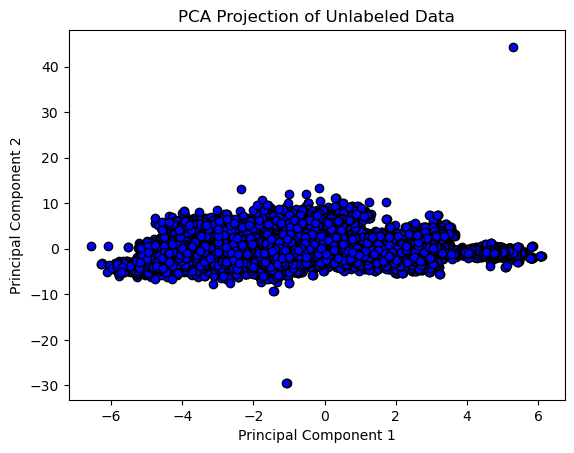

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], color='blue', edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Unlabeled Data")
plt.show()

# 1. DBSCAN

using knee method to find eps

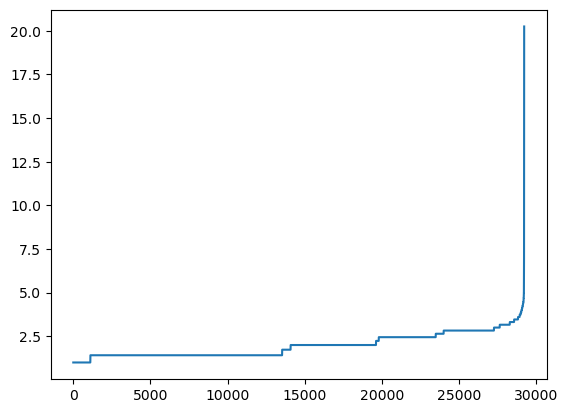

In [42]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_cleaned)
distances, indices = nbrs.kneighbors(df_cleaned)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Number of clusters: 41
Outliers: 228


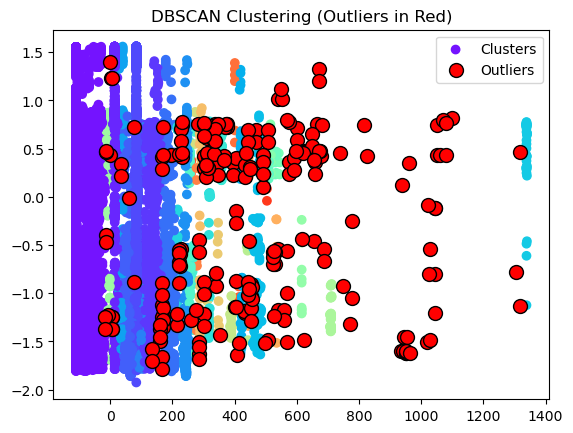

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Fit DBSCAN model using all features in df_cleaned
dbscan = DBSCAN(eps=4.5, min_samples=5)
y_pred = dbscan.fit_predict(df_cleaned)

# Print number of clusters and outliers
num_clusters = len(set(y_pred) - {-1})  # Excluding -1 (outliers)
num_outliers = np.sum(y_pred == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Outliers: {num_outliers}')

# Reduce the dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cleaned)

#Scatter plot
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_pred, cmap='rainbow', label='Clusters')
plt.scatter(df_pca[y_pred == -1, 0], df_pca[y_pred == -1, 1], color='red', s=100, label='Outliers', edgecolors='black')
plt.title("DBSCAN Clustering (Outliers in Red)")
plt.legend()
plt.show()


In [ ]:
#silhouette_score
score = silhouette_score(df_cleaned, dbscan.labels_)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.5490053096915954


# 2. Isolation Forest-model

In [ ]:
from sklearn.ensemble import IsolationForest


In [ ]:
# Create and fit the model
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # contamination is the expected fraction of outliers
df_cleaned['anomaly'] = iso_forest.fit_predict(df_cleaned)

# The output labels: 1 means normal, -1 means an anomaly (outlier)


In [ ]:
# Identify outliers (labeled as -1 in Isolation Forest)
outliers_if = df_cleaned[df_cleaned['anomaly'] == -1]

# Print outlier data points (attributes)
print(outliers_if)



          3wh    vpn    tor  encrypted  size  timeout  source_ip_1.0.254.69  \
131      True  False  False       True    45    False                 False   
134      True  False  False      False     0    False                 False   
250      True  False  False       True    45    False                 False   
634      True  False  False      False     0    False                 False   
754      True  False  False      False   137    False                 False   
...       ...    ...    ...        ...   ...      ...                   ...   
159476  False  False  False      False   103    False                 False   
159477   True  False  False      False     0    False                 False   
159542   True  False  False       True    41    False                 False   
159544   True  False  False      False     0    False                 False   
159545   True  False  False      False    51    False                 False   

        source_ip_1.1.227.13  source_ip_1.1.229.82 

In [ ]:
anomaly_counts = df_cleaned['anomaly'].value_counts()
print(anomaly_counts)

anomaly
 1    17379
-1     1931
Name: count, dtype: int64


In [ ]:
print(f"Anomalies: {sum(df_cleaned['anomaly'] == -1)} / {len(df_cleaned)}")

Anomalies: 1931 / 19310


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [0.5, 0.75, 1.0],
    'contamination': [0.05, 0.1, 0.2]  # Percentage of anomalies expected
}

# Initialize Isolation Forest
iso_forest = IsolationForest(random_state=42)

# Define a custom scoring function (higher is better)
def anomaly_score(estimator, X):
    scores = estimator.decision_function(X)  # Anomaly scores
    return np.mean(scores)  # Higher means better normal separation

scorer = make_scorer(anomaly_score, greater_is_better=True)

# Perform Grid Search
grid_search = GridSearchCV(iso_forest, param_grid, scoring=scorer, cv=3, n_jobs=-1)

# Fit the model
grid_search.fit(df_cleaned)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


D:\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'contamination': 0.05, 'max_features': 0.5, 'n_estimators': 100}


          3wh    vpn    tor  encrypted  size  timeout  source_ip_1.0.254.69  \
0        True  False  False      False    43    False                 False   
42       True  False  False      False   137    False                 False   
134      True  False  False      False     0    False                 False   
156      True  False  False      False     0    False                 False   
530     False  False  False      False   249    False                 False   
...       ...    ...    ...        ...   ...      ...                   ...   
157687   True  False  False      False   126    False                 False   
157763   True  False  False      False   193    False                 False   
158464   True  False  False      False    84    False                 False   
158669   True  False  False      False     0    False                 False   
159131   True  False  False      False     0    False                 False   

        source_ip_1.1.227.13  source_ip_1.1.229.82 

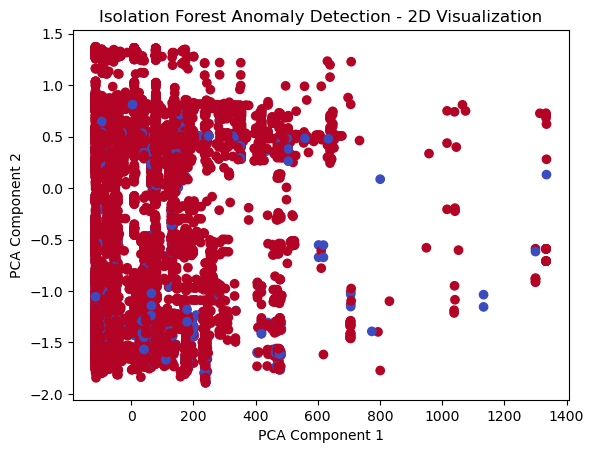

In [ ]:

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, max_features=0.5, max_samples='auto', n_estimators=100)
df_cleaned['anomaly'] = iso_forest.fit_predict(df_cleaned)

# Identify outliers (labeled as -1 in Isolation Forest)
outliers_if = df_cleaned[df_cleaned['anomaly'] == -1]

# Print outlier data points (attributes)
print(outliers_if)

# Print anomaly counts
anomaly_counts = df_cleaned['anomaly'].value_counts()
print(anomaly_counts)

# Print anomaly ratio
print(f"Anomalies: {sum(df_cleaned['anomaly'] == -1)} / {len(df_cleaned)}")

# Convert anomaly labels (1 for normal, 0 for anomalies) for silhouette scoring
labels = [0 if label == -1 else 1 for label in df_cleaned['anomaly']]

# Compute the Silhouette Coefficient
score = silhouette_score(df_cleaned.drop(columns=['anomaly']), labels)  # Dropping 'anomaly' column for features
print(f"Silhouette Score: {score}")

# Visualize the clusters in 2D using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df_cleaned.drop(columns=['anomaly']))

# Scatter plot of 2D representation of the data points
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='coolwarm')
plt.title("Isolation Forest Anomaly Detection - 2D Visualization")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


# one class svm

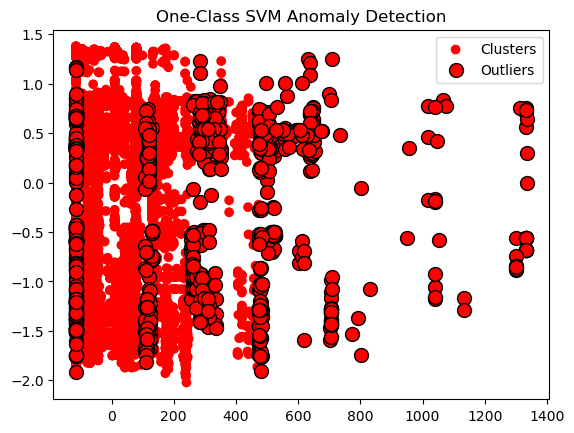

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

# Train One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
y_pred = oc_svm.fit_predict(df_cleaned)  # Predictions (-1 = anomaly, 1 = normal)


# Reduce the dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cleaned)

# Visualize results
#scatter Plot
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_pred, cmap='rainbow', label='Clusters')
plt.scatter(df_pca[y_pred == -1, 0], df_pca[y_pred == -1, 1], color='red', s=100, label='Outliers', edgecolors='black')
plt.title("One-Class SVM Anomaly Detection")
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score (only for clustered data)
silhouette = silhouette_score(df_cleaned, y_pred)
print(f"Silhouette Score: {silhouette:.4f}")


Silhouette Score: 0.6058
